In [223]:
import numpy as np
import pandas as pd
import sys
import functools
import matplotlib.pyplot as plt
from time import time

def get_summary(pipeline_func):
    @functools.wraps(pipeline_func)
    def wrapper(*args, **kwargs):
        assert isinstance(args[0], pd.core.frame.DataFrame)
        result_df = pipeline_func(*args, **kwargs)
        assert isinstance(result_df, pd.core.frame.DataFrame)
        print(result_df.shape)

        return result_df

    return wrapper

def get_data(filepath):
    print(f"reading from {filepath}")
    try:
        df = pd.read_csv(filepath)
        return df
    except:
        print("couldn't read data")
        return pd.DataFrame()

def pipeline(df, fns, name):
    intermediate = df
    print(f"RUNNING {name}")
    for i, fn in enumerate(fns):
        print(f"STEP {i+1}: {str(fn)}")
        intermediate = fn(intermediate)
        intermediate.reset_index(drop=True, inplace=True)
    print("[DONE] ------------\n")
    return intermediate

@get_summary
def initial(df):
    print(df.keys())
    return df

@get_summary
def top2k(df):
    return df[:2000]

@get_summary
def drop_columns(df):
    result = df[["category", "job_description", "is_fulltime"]]
    return result

@get_summary
def create_binary_job(df):
    df.loc[:, "is_fulltime"] = df.job_type == 'Full Time'
    return df

@get_summary
def task1_fields(df):
    return df[["job_description", "is_fulltime"]]

def get_category_proportions(df):
    print(df.category.value_counts() / sum(df.category.value_counts()))
    return df

@get_summary
def stratified_undersample_fulltime(df):
    other_count = len(df) - sum(df.is_fulltime)
    assert other_count == sum(~df.is_fulltime)
    
    all_indices = np.arange(len(df))
    fulltime_indices = all_indices[df.is_fulltime]
    other_indices = all_indices[~df.is_fulltime]
    
    # we need to select other_count indices out of the fulltime_indices list without replacement
    
    category_counts = other_count * (df.category.value_counts() / sum(df.category.value_counts()))
    category_counts = category_counts.astype(int)
    resulting_indices = []
    for category in df.category.unique():
        in_category_and_fulltime = all_indices[(df.is_fulltime) & (df.category == category)]
        choices = np.random.choice(in_category_and_fulltime, category_counts[category])
        resulting_indices.extend(choices)
        
    new_df = df.loc[[*resulting_indices, *other_indices]]
    return new_df
    
def display_category_count_stats(df):
    print(f"Category counts: {round(df.category.value_counts().mean(), 2)} ± {round(df.category.value_counts().std(), 2)}")
    return df
    
@get_summary
def delete_dupes(df):
    # Considers duplicate if job description is identical
    df = df.drop_duplicates(subset=["job_description"], keep='first')
    return df

def replace_empty_with_nan(df):
    df['job_description'].replace('', np.nan, inplace=True)
    return df

def which_na(df):
    print(df[df.job_description.isna()].category.value_counts())
    print(df[df.job_description.isna()].company_name.value_counts())
    return df
    
@get_summary
def delete_na(df):
    df.dropna(subset=['job_description'], inplace=True)
    return df
    
@get_summary
def random_undersample_categories(df):
    MAXIMUM_CLASS_COUNT = 1289
    
    undersampled_frame = pd.DataFrame()
    
    for class_name in df.category.unique():
        class_count = sum(df.category == class_name)
        if class_count > MAXIMUM_CLASS_COUNT:
            # Need to undersample this class
            undersampled = df[df.category == class_name].sample(MAXIMUM_CLASS_COUNT)
            undersampled_frame = pd.concat([undersampled_frame, undersampled])
        else:
            undersampled_frame = pd.concat([undersampled_frame, df[df.category == class_name]])
    
    return undersampled_frame

@get_summary
def random_oversample_categories(df):
    MINIMUM_CLASS_COUNT = 502
    
    oversampled_frame = pd.DataFrame()
    
    for class_name in df.category.unique():
        class_count = sum(df.category == class_name)
        if class_count < MINIMUM_CLASS_COUNT:
            # Need to oversample this class
            required_to_add = MINIMUM_CLASS_COUNT - class_count
            additional = df[df.category == class_name].sample(required_to_add, replace=True)
            oversampled_frame = pd.concat([oversampled_frame, additional])
        oversampled_frame = pd.concat([oversampled_frame, df[df.category == class_name]])
            
    return oversampled_frame
    
@get_summary
def naive_undersample_fulltime(df):
    other_count = len(df) - sum(df.is_fulltime)
    all_indices = np.arange(len(df))
    fulltime_indices = all_indices[df.is_fulltime]
    other_indices = all_indices[~df.is_fulltime]
    new_df = df.loc[[*np.random.choice(fulltime_indices, other_count), *other_indices]] 
    
    return new_df
    
@get_summary
def task2_fields(df):
    return df[["job_description", "category"]]

def display_balance(df):
    fulltime_prop = sum(df.is_fulltime) / len(df)
    print(f"FULL TIME %: {round(fulltime_prop * 100, 2)}%")
    print(f"OTHER %: {round((1 - fulltime_prop) * 100, 2)}%")
    return df

# Preprocessing Pipeline


In [224]:
origin_df = get_data('../data/seek_australia.csv')
result = pipeline(origin_df, [initial, create_binary_job, replace_empty_with_nan, which_na, delete_na, delete_dupes, drop_columns], "Initial pipeline")
task1_result = pipeline(result, [display_balance, stratified_undersample_fulltime, display_balance, task1_fields], "Task 1 pipeline")
task2_result = pipeline(result, [task2_fields, display_category_count_stats, random_undersample_categories, random_oversample_categories], "Task 2 pipeline")

reading from ../data/seek_australia.csv
RUNNING Initial pipeline
STEP 1: <function initial at 0x7f68ce4560d0>
Index(['category', 'city', 'company_name', 'geo', 'job_board',
       'job_description', 'job_title', 'job_type', 'post_date',
       'salary_offered', 'state', 'url'],
      dtype='object')
(30000, 12)
STEP 2: <function create_binary_job at 0x7f68cde44550>
(30000, 13)
STEP 3: <function replace_empty_with_nan at 0x7f68d0bb8b80>
STEP 4: <function which_na at 0x7f68d0bb85e0>
Information & Communication Technology    38
Manufacturing, Transport & Logistics      36
Trades & Services                         35
Legal                                     25
Healthcare & Medical                      25
Administration & Office Support           25
Marketing & Communications                21
Sales                                     20
Education & Training                      14
Hospitality & Tourism                     14
Government & Defence                      14
Construction       

# Job description-less jobs:

There are a few companies (170 unique companies) which have made job listings with no job description. Unfortunately, these listings will be removed from the dataset.

Here's a small subsection of the companies and how many empty job listings they've made so that we're aware of the bias we're introducing:
```
Kaleidoscope Legal Recruitment          23
Excel Recruitment                       16
Private Advertiser                      11
Department of Education and Training    10
Melbourne Water                          7
...
Genea                                    1
Platinum People Solutions                1
Camnet                                   1
Blue Line Cruises                        1
Metro Ice Cream Distribution Pty Ltd     1
```

# Dealing with Data Imbalance

## Task 1

### Undersampling
In our case, some classes appear more frequently than others. (e.g. there are more full time jobs than any other kind). We want to try to ensure an equal balance between our classes. Since our dataset is relatively large, we can afford to undersample, this is the process where we intentionally remove samples from our larger class, reducing the overall size of our dataset.
Naively undersampling the `is_fulltime` field will result in a biased dataset. This is because we are ignoring our knowledge of the various job categories. By naively undersampling we are probably going to change the proportion of the different job categories, e.g. we just happen to (by bad luck) disproporitonately remove a bunch of law firm jobs. This will hence skew the `job_description` data. In an attempt to mitigate this issue, we will attempt to keep the category proporitions the same when we undersample from the `is_fulltime` column. Hence we will perform a **stratified** sample of the data where the strata are the various categories.

## Task 2

### Undersampling & Oversampling
Will perform over and undersampling to try and improve class balance. The mean number of data points per class is calculated above (895.03) and the standard deviation is too (787.01). Based purely on intuition, I will resample so that the maximum number of data points per class is is  
`895 + 0.5 * 787 = 1289` and the minimum number is `895 - 0.5 * 787 = 502`. So in total, our range of data point counts per class will span from 36 to 98 (still unideal, but better than initially). 895.03 ± 787.01

# What the datasets look like now:

In [225]:
task1_result

,job_description,is_fulltime
0,Telstra is Australia's leading telecommunicat...,True
1,"About the Company: Award-winning, Australian m...",True
2,Salary 50k+ + $ overtime + 11% Super Monthly ...,True
3,Would you love to help lead a service orienta...,True
4,Peter Stevens motorcyclesÂ Dandenong are look...,True
...,...,...
17786,About Us Kaplan Australia is one of the world...,False
17787,"Full-Time, Maximum Term Position (10 Months)Â...",False
17788,MondelÄ“z International is currently seeking ...,False
17789,Long term contract for 12 months with possibl...,False


Text(0.5, 0, 'Class')

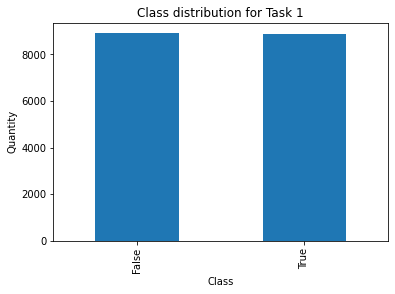

In [229]:
task1_result.is_fulltime.value_counts().plot.bar()
plt.title("Class distribution for Task 1")
plt.ylabel("Quantity")
plt.xlabel("Class")

<AxesSubplot:>

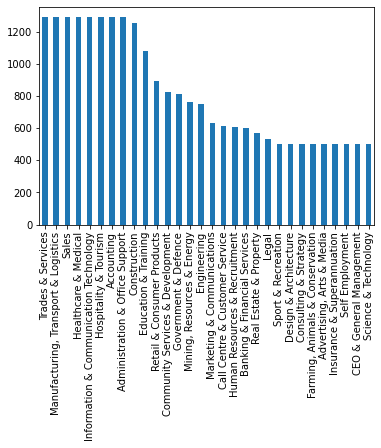

In [230]:
task2_result.category.value_counts().plot.bar()

In [231]:
task2_result.category.value_counts()
print(f"{task2_result.category.value_counts().mean()} ± {task2_result.category.value_counts().std()}")

825.3333333333334 ± 335.003276703824
